In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataset import TranslationDataset, Vocab

max_len = 48
min_freq_src = 4
min_freq_trg = 4

embedding_dim = 128
hidden_size = 256
learning_rate = 5e-3
gamma = 0.1
num_epochs = 12
weight_decay = 1e-5
label_smoothing = 0.05
dropout = 0.2


extract_to = '../'
data_folder = extract_to + 'data/'
train_src_filename = data_folder + 'train.de-en.de'
train_trg_filename = data_folder + 'train.de-en.en'
test_src_filename = data_folder + 'val.de-en.de'
test_trg_filename = data_folder + 'val.de-en.en'
submission_filename = data_folder + 'test1.de-en.de'

device = 'cpu'

vocab_src = Vocab(train_src_filename, min_freq=min_freq_src)
vocab_trg = Vocab(train_trg_filename, min_freq=min_freq_trg)

train_dataset = TranslationDataset(vocab_src, 
                                   vocab_trg, 
                                   train_src_filename, 
                                   train_trg_filename, 
                                   max_len=max_len, 
                                   device=device)
test_dataset = TranslationDataset(vocab_src, 
                                  vocab_trg, 
                                  test_src_filename, 
                                  test_trg_filename, 
                                  max_len=72, 
                                  device=device, 
                                  sort_lengths=True)

from dataset import TrainDataLoader, TestDataLoader
unk_idx, pad_idx, bos_idx, eos_idx = 0, 1, 2, 3

train_loader = TrainDataLoader(train_dataset, shuffle=True)
test_loader = TestDataLoader(test_dataset)

import torch.nn as nn
from lstm2 import LSTM_2, train
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

src_vocab_size = len(vocab_src)
trg_vocab_size = len(vocab_trg)

model = LSTM_2(
    src_vocab_size=src_vocab_size,
    trg_vocab_size=trg_vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    dropout=dropout
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx, label_smoothing=label_smoothing)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=gamma, verbose=True)
print(model)


100%|██████████| 986/986 [00:00<00:00, 26793.72it/s]


LSTM_2(
  (src_embedding): Embedding(30249, 128)
  (trg_embedding): Embedding(21950, 128)
  (encoder): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (encoder_output_proj): Linear(in_features=512, out_features=256, bias=True)
  (decoder): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2)
  (encoder_hidden_proj): ModuleList(
    (0-1): 2 x Linear(in_features=512, out_features=256, bias=True)
  )
  (encoder_cell_proj): ModuleList(
    (0-1): 2 x Linear(in_features=512, out_features=256, bias=True)
  )
  (fc): Linear(in_features=512, out_features=21950, bias=True)
)


c:\Users\Dubinin Daniil\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

21887550

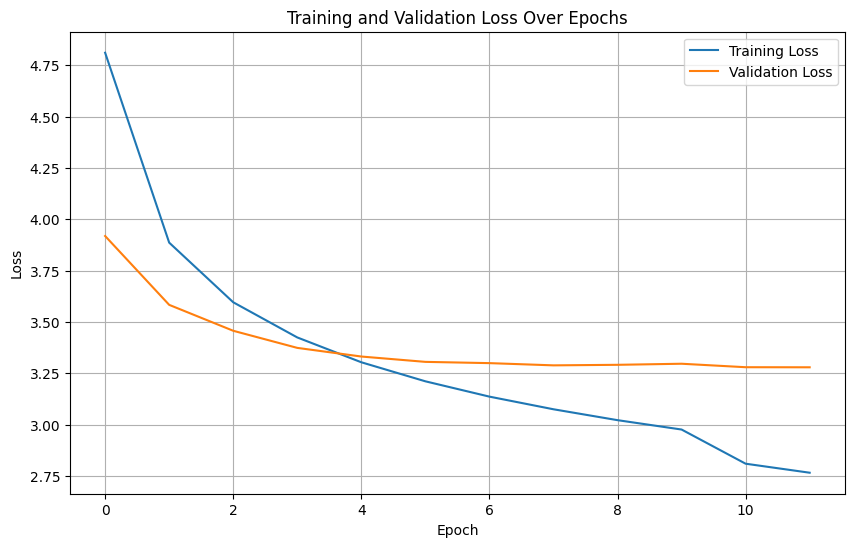

In [4]:
from lstm2 import plot_losses
model.load('lstm2-regular-12epoch.pt')
train_losses, val_losses = model.train_loss, model.val_loss
plot_losses(train_losses, val_losses)

In [5]:
# optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=weight_decay)
# scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=gamma, verbose=True, threshold=1e-3)
# train_losses, val_losses = train(model, 
#                                  optimizer, 
#                                  num_epochs, 
#                                  train_loader, 
#                                  test_loader, 
#                                  criterion, 
#                                  vocab_trg, 
#                                  scheduler)
# plot_losses(train_losses, val_losses)

In [6]:
from submission import get_bleu

In [12]:
model.to(device)
get_bleu(model, test_loader, vocab_trg, device=device)

100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


28.38

In [8]:
# model.save('lstm-deep-cut-vocab-12epoch.pt')


In [11]:
from submission import make_submission
from dataset import SubmissionDataset, SubmissionDataLoader
submission_dataset = SubmissionDataset(submission_filename, vocab_src, device=device)
ldr = SubmissionDataLoader(submission_dataset)
make_submission(model, ldr, vocab_trg, device=device)

100%|██████████| 24/24 [00:49<00:00,  2.04s/it]
